# Getting Started with invertmeeg

This notebook walks through the core workflow:
1. Create a forward model and EEG montage
2. Simulate EEG data
3. Recover sources with the OmniChampagne solver
4. Visualize results

In [1]:
# %matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mne

from invert import Solver
from invert.forward import create_forward_model, get_info
from invert.simulate import SimulationGenerator, SimulationConfig

## 1. Create a Forward Model

We use the fsaverage template with a standard EEG montage. `ico2` gives a
small source space that is fast to compute.

In [3]:
info = get_info(kind="biosemi32")
fwd = create_forward_model(sampling="ico3", info=info)

leadfield = fwd["sol"]["data"]
print(f"Leadfield shape: {leadfield.shape}  (channels x dipoles)")

/Users/lukas/projects/invert/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Leadfield shape: (32, 1284)  (channels x dipoles)


## 2. Simulate EEG Data

We generate one sample with a few focal sources and moderate noise.

In [4]:
config = SimulationConfig(
    batch_size=1,
    n_sources=(2, 2),
    n_orders=(0, 3),
    snr_range=(1, 1),
    n_timepoints=50,
)
gen = SimulationGenerator(fwd, config=config)
x, y, sim_info = next(gen.generate())

print(f"EEG data shape:    {x.shape}  (batch, channels, time)")
print(f"Source data shape:  {y.shape}  (batch, dipoles, time)")

EEG data shape:    (1, 32, 50)  (batch, channels, time)
Source data shape:  (1, 1284, 50)  (batch, dipoles, time)


### Wrap the simulated data in an `mne.EvokedArray`

The solver expects an MNE data object, so we create one from our numpy array.

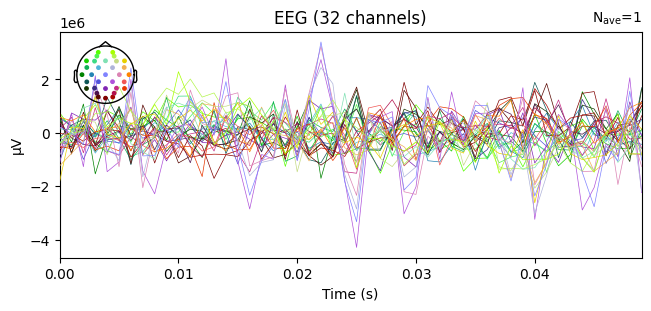

In [5]:
evoked = mne.EvokedArray(x[0], info, tmin=0)
evoked.plot(time_unit="s")
plt.show()

## 3. Compute the Inverse Solution with OmniChampagne

In [ ]:
# solver = Solver("OmniChampagne")
# solver = Solver("esmv")
# solver = Solver("subspace-sbl-plus")
# solver = Solver("subspace-sbl")
solver.make_inverse_operator(fwd, evoked)
stc = solver.apply_inverse_operator(evoked)

print(f"SourceEstimate shape: {stc.data.shape}  (dipoles x time)")

SourceEstimate shape: (1284, 50)  (dipoles x time)


## 4. Visualize the Results

### 4a. Ground truth vs. reconstruction (time-course overview)

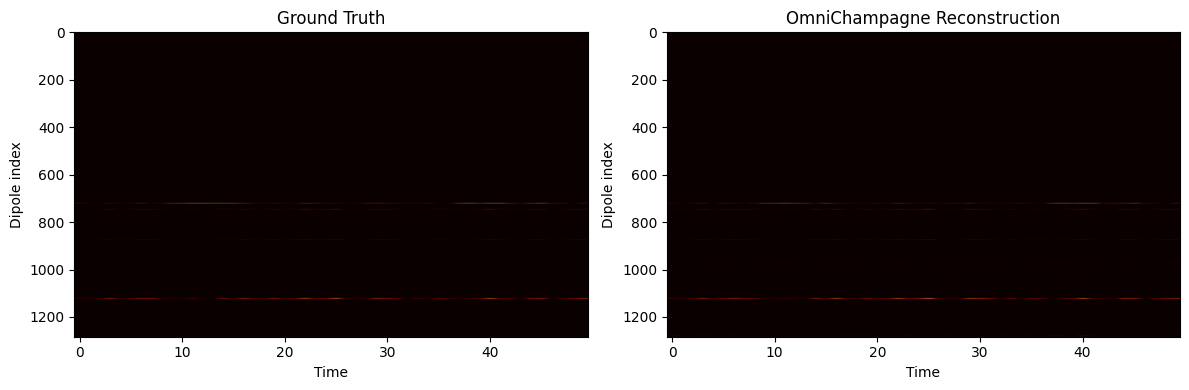

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].imshow(np.abs(y[0]), aspect="auto", cmap="hot")
axes[0].set_title("Ground Truth")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Dipole index")

axes[1].imshow(np.abs(stc.data), aspect="auto", cmap="hot")
axes[1].set_title("OmniChampagne Reconstruction")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Dipole index")

plt.tight_layout()
plt.show()

### 4b. Ground truth SourceEstimate on the brain

In [8]:
import os

fs_dir = mne.datasets.fetch_fsaverage(verbose=0)
subjects_dir = os.path.dirname(fs_dir)

src = fwd["src"]
vertices = [src[0]["vertno"], src[1]["vertno"]]
sfreq = info["sfreq"]

stc_true = mne.SourceEstimate(
    y[0], vertices=vertices, tmin=0, tstep=1.0 / sfreq, subject="fsaverage"
)

### 4c. Plot reconstruction on the cortical surface

Pick the time point with maximum activation and plot both ground truth and
reconstruction side by side.

In [9]:
peak_time = stc.times[np.argmax(np.max(np.abs(stc.data), axis=0))]

stc.subject = "fsaverage"
plot_kwargs = dict(
    subjects_dir=subjects_dir,
    subject="fsaverage",
    surface="inflated",
    hemi="both",
    cortex="low_contrast",
    initial_time=peak_time,
    time_unit="s",
    size=(800, 400),
    smoothing_steps=10,
    verbose=0,
)

brain_true = stc_true.plot(brain_kwargs=dict(title="Ground Truth"), **plot_kwargs)
brain_est = stc.plot(brain_kwargs=dict(title=solver.name), **plot_kwargs)

Using control points [0.00000000e+00 1.56216542e-06 7.72355083e-03]
